In [50]:
# imports
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import backend as K
from keras import activations
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [51]:
# load data into memory.
base_path = "../data/required_2D_Data"
extension = '.png'
num_classes = 2

X = []
Y = []
for file in os.listdir(base_path):
    if file.endswith(extension):
        image_path = os.path.join(base_path, file)
        image = load_img(image_path)
        x = img_to_array(image)
        x = x.reshape((1,) + x.shape)
        X.append(x)
        label = file.split('_')[0]
        if(label=='AD'):
            Y.append(0)
        if(label=='MCI'):
            Y.append(1)
        if(label=='MCI2AD'):
            Y.append(2)
        if(label=='MCI2NC'):
            Y.append(3)
        if(label=='NC'):
            Y.append(4)

In [52]:
X = np.array(X).reshape(-1, 288, 432, 3)
X = X.astype('float32')
X = X / 255.
# split data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=1)

In [53]:
# model
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(288, 432, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax', name='visualized_layer'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 286, 430, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 143, 215, 32)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 143, 215, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 141, 213, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 70, 106, 64)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 70, 106, 64)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 68, 104, 64)      

In [55]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train, Y_train, epochs=5, 
                    validation_data=(X_test, Y_test))

Train on 379 samples, validate on 43 samples
Epoch 1/5
379/379 [==============================] - 51s 136ms/sample - loss: 0.6404 - acc: 0.6728 - val_loss: 0.6854 - val_acc: 0.6279
Epoch 2/5
379/379 [==============================] - 47s 125ms/sample - loss: 0.6404 - acc: 0.6728 - val_loss: 0.6854 - val_acc: 0.6279
Epoch 3/5
379/379 [==============================] - 48s 125ms/sample - loss: 0.6404 - acc: 0.6728 - val_loss: 0.6854 - val_acc: 0.6279
Epoch 4/5
379/379 [==============================] - 48s 128ms/sample - loss: 0.6404 - acc: 0.6728 - val_loss: 0.6854 - val_acc: 0.6279
Epoch 5/5
379/379 [==============================] - 48s 126ms/sample - loss: 0.6404 - acc: 0.6728 - val_loss: 0.6854 - val_acc: 0.6279


In [15]:
model.save("../model/2dCNN.h5")

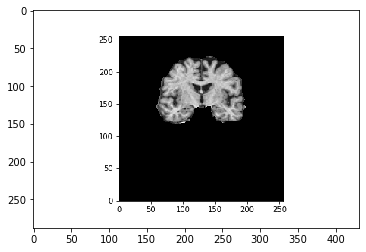

In [13]:
#!pip install scipy==1.1.0
#!pip install keras-vis
from vis.visualization import visualize_saliency,visualize_activation
from vis.utils import utils
from keras import activations
import matplotlib.image as mpimg
import scipy.ndimage as ndimage
from PIL import Image
im = Image.open('../data/required_2D_Data/NC_4TP_0048_NORMAL-sc-1_128.png')
im.show()


img = mpimg.imread("../data/required_2D_Data/NC_4TP_0048_NORMAL-sc-1_128.png")
plt.imshow(img)

In [56]:
#!pip install git+https://github.com/raghakot/keras-vis.git -U
from keras.models import load_model
from keras.utils import CustomObjectScope
from keras.initializers import glorot_uniform

model = load_model('../model/2dCNN.h5', custom_objects={'GlorotUniform': glorot_uniform()})

# model = load_model('../model/2dCNN.h5')
# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#     model = load_model('../model/2dCNN.h5')
        
# Find the index of the to be visualized layer above
layer_index = utils.find_layer_idx(model, 'visualized_layer')

# Swap softmax with linear
model.layers[layer_index].activation = activations.linear
model = utils.apply_modifications(model)

ValueError: Invalid Reduction Key auto.

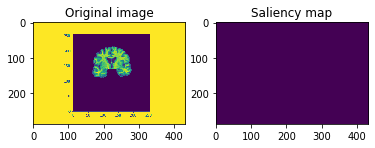

<Figure size 1080x1080 with 0 Axes>

In [57]:
# Matplotlib preparations
fig, axes = plt.subplots(1, 2)
plt.figure(figsize=(15,15))
# Generate visualization
visualization = visualize_saliency(model, layer_index, filter_indices=None, seed_input=X_test[0])
axes[0].imshow(X_test[0][..., 0]) 
axes[0].set_title('Original image')
axes[1].imshow(visualization)
axes[1].set_title('Saliency map')
plt.show()

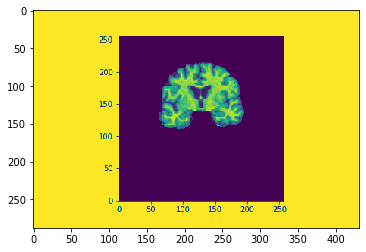

In [26]:
filter_idx = 0
img = visualize_activation(model, layer_index, filter_indices=filter_idx)
plt.imshow(X_test[0][..., 0])

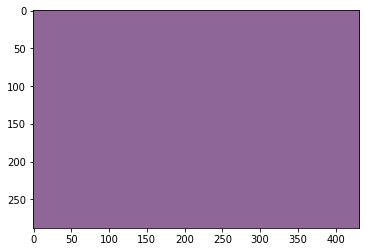

In [32]:
grads = visualize_saliency(model, layer_index, filter_indices=None,
                          seed_input=X_test[0], backprop_modifier=None)
plt.imshow(grads, alpha=0.6)

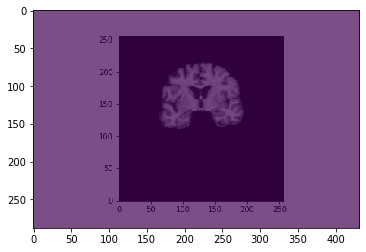

In [39]:
gaus = ndimage.filters.gaussian_filter(grads[:,:], sigma=5)
plt.imshow(X_test[0])
plt.imshow(gaus, alpha=0.7)

In [36]:
#!pip uninstall opencv-contrib-python
#!pip uninstall opencv-python
#!pip install opencv-contrib-python --user
import cv2

image = X_test[0]

saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
(success, saliencyMap) = saliency.computeSaliency(image)
saliencyMap = (saliencyMap * 255).astype("uint8")
cv2.imshow("Image", image)
cv2.imshow("Output", saliencyMap)
cv2.waitKey(0)

-1